## EDA and Wrangling

Since this dataset has relatively few columns, there's not much to explore.  
  
However, I did identify the following avenues for improvement:  
  
1. We've only scraped a maximum of 10 reviews per user. Re-visiting those users' pages and looking for more reivews might make for a quick increase in our overall review count, since these are our proven high-review-count users.

2. There's a slight issue with our "helpful" counts: when there is no helpful count but there IS a "funny" count (funny counts went unnoticed in my scraper design), the funny count is recorded as the helpful count. Fortunately this doesn't seem to have happened too much, and the funny count may also be a reasonable indicator of the utility of the review.

In [28]:
import pandas as pd
import numpy as np

import pyarrow.parquet as pq
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

### EDA: Reviews

In [17]:
review_table = pq.read_table('../data/raw/review_table.parquet')
review_df = review_table.to_pandas()
review_table = None
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 315083 entries, 0 to 315082
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   user             315083 non-null  object 
 1   app_id           315083 non-null  int64  
 2   positive         315083 non-null  int64  
 3   total_playtime   315083 non-null  float64
 4   review_playtime  315083 non-null  float64
 5   text             315083 non-null  object 
 6   helpful_count    315083 non-null  int64  
 7   review_date      315083 non-null  object 
 8   edit_date        315083 non-null  object 
 9   date_scraped     315083 non-null  object 
dtypes: float64(2), int64(3), object(5)
memory usage: 24.0+ MB


In [18]:
for col in review_df.columns :
    print(f'-----{col}-----')
    print(review_df[col].describe())
    print('')

-----user-----
count                315083
unique                84310
top       76561198046553420
freq                     10
Name: user, dtype: object

-----app_id-----
count    3.150830e+05
mean     6.471635e+05
std      5.873518e+05
min      1.000000e+01
25%      2.346500e+05
50%      4.312500e+05
75%      1.063730e+06
max      2.900190e+06
Name: app_id, dtype: float64

-----positive-----
count    315083.000000
mean          0.847872
std           0.359146
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: positive, dtype: float64

-----total_playtime-----
count    315083.000000
mean        436.878629
std        1371.562472
min           0.000000
25%           9.600000
50%          43.400000
75%         214.700000
max       71930.600000
Name: total_playtime, dtype: float64

-----review_playtime-----
count    315083.000000
mean        207.992592
std         746.624910
min           0.000000
25%           4.800000


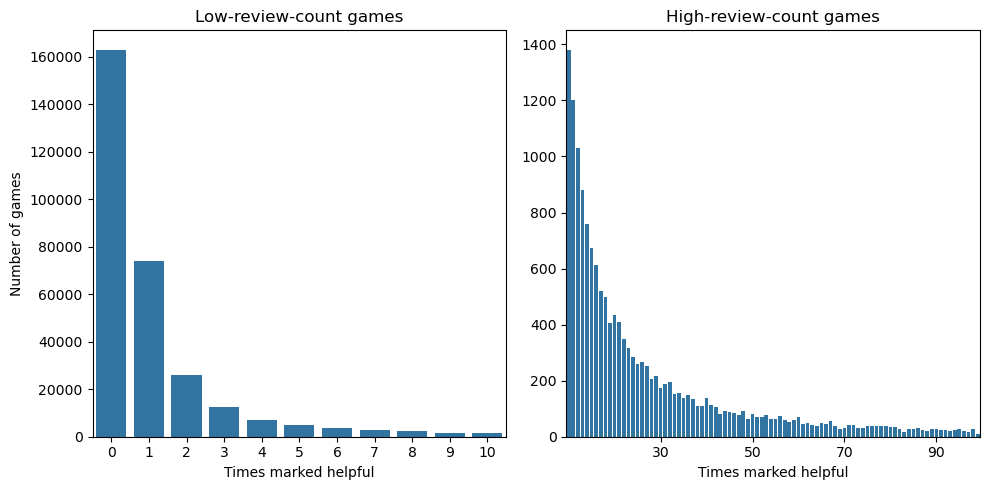

In [19]:
helpful_counts = review_df['helpful_count'].value_counts()
helpful_counts.sort_index(inplace=True)
low_review = helpful_counts[:11]
high_review = helpful_counts[10:100]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.barplot(x=low_review.index, y=low_review.values, ax=ax[0])
ax[0].set_title('Low-review-count games')
ax[0].set_xlabel('Times marked helpful')
ax[0].set_ylabel('Number of games')
sns.barplot(x=high_review.index, y=high_review.values, ax=ax[1])
ax[1].set_title('High-review-count games')
ax[1].set_xlabel('Times marked helpful')
ax[1].set_xticks([20, 40, 60, 80])

plt.tight_layout()
plt.show()

In [20]:
unplayed_reviews = review_df[review_df['review_playtime']<0.0001]

print(f"{len(unplayed_reviews)} games were reviewed without being played.")

5020 games were reviewed without being played.


In [21]:
played_reviews = review_df[review_df['review_playtime']>0.0001]

pos_unplayed_review_percent = unplayed_reviews['positive'].sum()/len(unplayed_reviews)
pos_played_review_percent = played_reviews['positive'].sum()/len(played_reviews)

print(f'Positive review percent of played games: {pos_played_review_percent:.2f}')
print(f'Positive review percent of unplayed games: {pos_unplayed_review_percent:.2f}')

Positive review percent of played games: 0.85
Positive review percent of unplayed games: 0.72


Text(0, 0.5, 'Count')

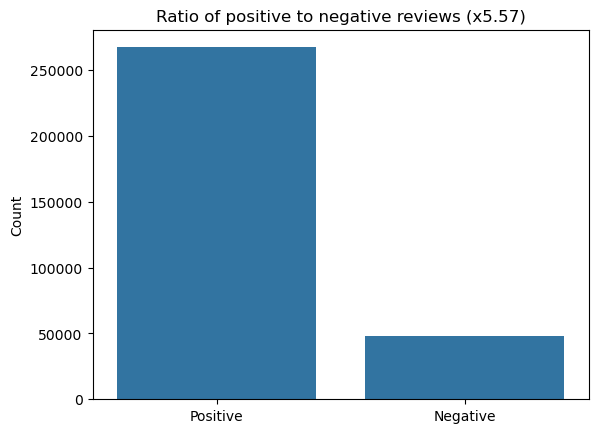

In [22]:
positives = review_df['positive'].sum()
negatives = len(review_df) - positives
ratio = positives/negatives
sns.barplot(x=['Positive', 'Negative'], y=[positives, negatives])
plt.title(f'Ratio of positive to negative reviews (x{round(ratio, 2)})')
plt.ylabel('Count')

<Axes: >

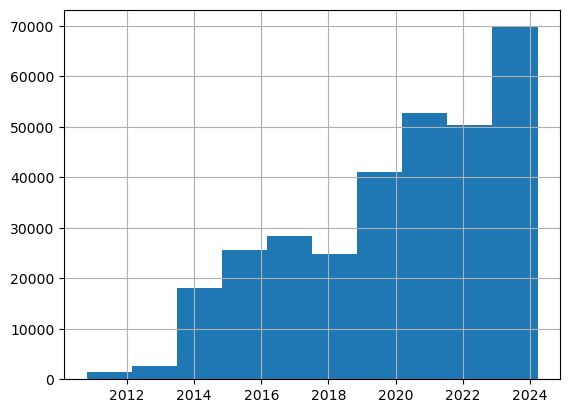

In [23]:
review_df['review_date'].hist()

In [24]:
late_edits = review_df[review_df['review_date'] != review_df['edit_date']]
review_lags = late_edits['edit_date'] - late_edits['review_date']
review_lags.describe()

count                          29903
mean     533 days 11:24:31.999464944
std      705 days 06:15:14.530201272
min                  1 days 00:00:00
25%                 25 days 00:00:00
50%                250 days 00:00:00
75%                750 days 00:00:00
max               4756 days 00:00:00
dtype: object

In [25]:
review_texts = review_df['text']
review_texts.describe()

count     315083
unique    280152
top         good
freq        1255
Name: text, dtype: object

Text(0, 0.5, 'Number of users with that many reviews')

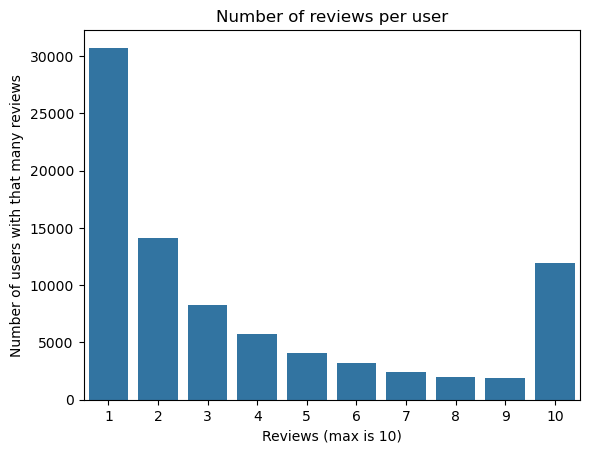

In [26]:
review_counts = review_df['user'].value_counts()
grouped_counts = review_counts.groupby(review_counts).agg('count')

sns.barplot(x=grouped_counts.index, y=grouped_counts.values)
plt.title('Number of reviews per user')
plt.xlabel('Reviews (max is 10)')
plt.ylabel('Number of users with that many reviews')

### EDA: Recently Played

The above data was scraped from the webpage. The following data was collected from the API. That's the reason for the different size of the dataset, as well as the overlapping data (specifically, a player's lifetime playtime for a game).

Ideally, we could combine these datasets into one table, as it would have no repeated information, though there would be quite a few nulls where one dataset was smaller than the other. However, this task may not be within the scope of the current modeling project.

The data for recently played games is stored in a tuple with the following schema:  
  
  -- user id (str)  
  -- app id (int)  
  -- time played in last 2 weeks (int, minutes)  
  -- time played in forever (int, minutes)


In [46]:
with open('../data/raw/recently_played.pkl', 'rb+') as file:
    recently_played_tuples = pickle.load(file)

recently_played_df = pd.DataFrame(recently_played_tuples, columns=['user', 'app_id', 'playtime_2w', 'playtime_f'])
recently_played_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1683058 entries, 0 to 1683057
Data columns (total 4 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   user         1683058 non-null  object
 1   app_id       1683058 non-null  int64 
 2   playtime_2w  1683058 non-null  int64 
 3   playtime_f   1683058 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 51.4+ MB


In [55]:
recently_played_df.describe()

,app_id,playtime_2w,playtime_f
count,1.683058e+06,1.683058e+06,1.683058e+06
mean,8.871855e+05,5.800291e+02,3.516038e+04
std,7.538794e+05,1.510151e+03,1.237312e+05
min,7.000000e+00,1.000000e+00,0.000000e+00
25%,2.841600e+05,2.900000e+01,3.510000e+02
50%,5.946500e+05,1.260000e+02,2.437000e+03
75%,1.328670e+06,5.100000e+02,1.582300e+04
max,2.902410e+06,2.015900e+04,5.574135e+06


C:\Users\Josh\AppData\Local\Temp\ipykernel_38620\3816339695.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  groupby_apps = recently_played_df.groupby('app_id').agg('mean') \


array([[<Axes: title={'center': 'playtime_2w'}>,
        <Axes: title={'center': 'playtime_f'}>]], dtype=object)

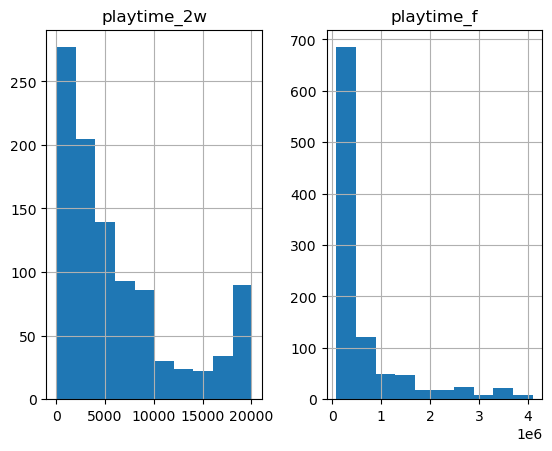

In [59]:
groupby_apps = recently_played_df.groupby('app_id').agg('mean') \
                                 .sort_values(by='playtime_f', ascending=False)
groupby_apps[:1000].hist()

In [60]:
# The playtime_2w column is very instructive in that there's a huge amount
# of records with about 20k minutes of playtime, which is also roughly
# the amount of minutes in 2 weeks.

# This suggests that some people may just leave games running.

max_playtime = recently_played_df[recently_played_df['playtime_2w'] > 20000]
max_playtime.describe()


,app_id,playtime_2w,playtime_f
count,8.350000e+02,835.000000,8.350000e+02
mean,5.893876e+05,20064.898204,1.927071e+06
std,5.985079e+05,31.927683,1.399451e+06
min,1.000000e+01,20001.000000,2.245800e+04
25%,2.168600e+05,20040.000000,5.073370e+05
50%,4.035700e+05,20061.000000,2.020583e+06
75%,8.148750e+05,20089.000000,3.268261e+06
max,2.784840e+06,20159.000000,5.574135e+06


---------------

In [57]:
with open('../data/raw/0 - Scraped Games DF.pkl', 'rb+') as file:
    games_df = pickle.load(file)

In [58]:
games_df[games_df['app_id']==553850]

,app_id,title,release_date,positive_review_percent,number_of_reviews,price,game_page_link,tags,date_scraped,developer,...,norwegian,polish,brazilian,romanian,russian,finnish,swedish,turkish,vietnamese,tag_list
1,553850,HELLDIVERS™ 2,2022-08-22 00:00:00,0.72,124161.0,3999.0,https://store.steampowered.com/app/553850/HELL...,"[19, 3843, 3859, 3814, 1685, 1774, 6730]",2024-02-23,[Arrowhead Game Studios],...,118995.0,1020.0,1349.0,27.0,2268.0,118689.0,119026.0,317.0,12.0,"[Action, Online Co-Op, Third-Person Shooter, M..."


In [ ]:
553850